# Clustering Weather data with KMeans
We will use cluster analysis to generate a big picture model of the weather at a local station of San Diego using a minute-graunlarity data.

### Importing the Necessary Libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
#import utils
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from pandas.tools.plotting import parallel_coordinates

%matplotlib inline

### Creating a Pandas DataFrame from a CSV file

In [2]:
data = pd.read_csv('./weather/minute_weather.csv')

## Minute Weather Data Description

The **minute weather dataset** comes from the same source as the daily weather dataset that we used in the decision tree based classifier notebook. The main difference between these two datasets is that the minute weather dataset contains raw sensor measurements captured at one-minute intervals. Daily weather dataset instead contained processed and well curated data. The data is in the file **minute_weather.csv**, which is a comma-separated file.

As with the daily weather data, this data comes from a weather station located in San Diego, California. The weather station is equipped with sensors that capture weather-related measurements such as air temperature, air pressure, and relative humidity. Data was collected for a period of three years, from September 2011 to September 2014, to ensure that sufficient data for different seasons and weather conditions is captured.

Each row in **minute_weather.csv** contains weather data captured for a one-minute interval. Each row, or sample, consists of the following variables:

* **rowID:** 	unique number for each row	(*Unit: NA*)
* **hpwren_timestamp:**	timestamp of measure	(*Unit: year-month-day hour:minute:second*)
* **air_pressure:** air pressure measured at the timestamp	(*Unit: hectopascals*)
* **air_temp:**	air temperature measure at the timestamp	(*Unit: degrees Fahrenheit*)
* **avg_wind_direction:**	wind direction averaged over the minute before the timestamp	(*Unit: degrees, with 0 means coming from the North, and increasing clockwise*)
* **avg_wind_speed:**	wind speed averaged over the minute before the timestamp	(*Unit: meters per second*)
* **max_wind_direction:**	highest wind direction in the minute before the timestamp	(*Unit: degrees, with 0 being North and increasing clockwise*)
* **max_wind_speed:**	highest wind speed in the minute before the timestamp	(*Unit: meters per second*)
* **min_wind_direction:**	smallest wind direction in the minute before the timestamp	(*Unit: degrees, with 0 being North and inceasing clockwise*)
* **min_wind_speed:**	smallest wind speed in the minute before the timestamp	(*Unit: meters per second*)
* **rain_accumulation:**	amount of accumulated rain measured at the timestamp	(*Unit: millimeters*)
* **rain_duration:**	length of time rain has fallen as measured at the timestamp	(*Unit: seconds*)
* **relative_humidity:**	relative humidity measured at the timestamp	(*Unit: percent*)

In [3]:
data.shape

(1587257, 13)

In [4]:
data.head()

,rowID,hpwren_timestamp,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,rain_accumulation,rain_duration,relative_humidity
0,0,2011-09-10 00:00:49,912.3,64.76,97.0,1.2,106.0,1.6,85.0,1.0,NaN,NaN,60.5
1,1,2011-09-10 00:01:49,912.3,63.86,161.0,0.8,215.0,1.5,43.0,0.2,0.0,0.0,39.9
2,2,2011-09-10 00:02:49,912.3,64.22,77.0,0.7,143.0,1.2,324.0,0.3,0.0,0.0,43.0
3,3,2011-09-10 00:03:49,912.3,64.40,89.0,1.2,112.0,1.6,12.0,0.7,0.0,0.0,49.5
4,4,2011-09-10 00:04:49,912.3,64.40,185.0,0.4,260.0,1.0,100.0,0.1,0.0,0.0,58.8


### Data Sampling

Since there are lots of records, let us sample down by taking every 10th row.

In [5]:
sampled_df = data[(data['rowID'] % 10) == 0]
sampled_df.shape

(158726, 13)

### Statistics:

In [6]:
#transpose will transpose the display of the dataframe
sampled_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rowID,158726.0,793625.000000,458203.937509,0.00,396812.5,793625.00,1190437.50,1587250.00
air_pressure,158726.0,916.830161,3.051717,905.00,914.8,916.70,918.70,929.50
air_temp,158726.0,61.851589,11.833569,31.64,52.7,62.24,70.88,99.50
avg_wind_direction,158680.0,162.156100,95.278201,0.00,62.0,182.00,217.00,359.00
avg_wind_speed,158680.0,2.775215,2.057624,0.00,1.3,2.20,3.80,31.90
max_wind_direction,158680.0,163.462144,92.452139,0.00,68.0,187.00,223.00,359.00
max_wind_speed,158680.0,3.400558,2.418802,0.10,1.6,2.70,4.60,36.00
min_wind_direction,158680.0,166.774017,97.441109,0.00,76.0,180.00,212.00,359.00
min_wind_speed,158680.0,2.134664,1.742113,0.00,0.8,1.60,3.00,31.60
rain_accumulation,158725.0,0.000318,0.011236,0.00,0.0,0.00,0.00,3.12


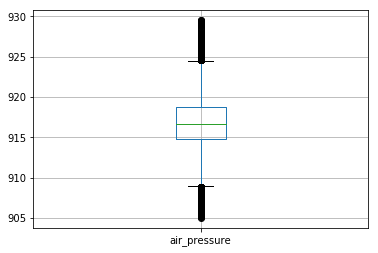

In [7]:
sampled_df.boxplot(column='air_pressure', figsize=(8,8))

In [8]:
sampled_df.isnull().sum()

rowID                  0
hpwren_timestamp       0
air_pressure           0
air_temp               0
avg_wind_direction    46
avg_wind_speed        46
max_wind_direction    46
max_wind_speed        46
min_wind_direction    46
min_wind_speed        46
rain_accumulation      1
rain_duration          1
relative_humidity      0
dtype: int64

In [9]:
sampled_df[sampled_df['rain_accumulation'] == 0].shape

(157812, 13)

In [10]:
sampled_df[sampled_df['rain_duration'] == 0].shape

(157237, 13)

### Drop columns 'rain_duration' and 'rain_accumulation'. Also Drop all rows with Empty Records

In [11]:
del sampled_df['rain_accumulation']
del sampled_df['rain_duration']

In [12]:
#rows_before = sampled_df.shape[0]
sampled_df = sampled_df.dropna()
#rows_after = sampled_df.shape[0]
#rows_after-rows_before

In [13]:
sampled_df.columns

Index(['rowID', 'hpwren_timestamp', 'air_pressure', 'air_temp',
       'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction',
       'max_wind_speed', 'min_wind_direction', 'min_wind_speed',
       'relative_humidity'],
      dtype='object')

### Select Features of Interest for Clustering

In [14]:
features = ['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 
        'max_wind_speed','relative_humidity']

In [15]:
select_df = sampled_df[features]

In [16]:
select_df.columns

Index(['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed',
       'max_wind_direction', 'max_wind_speed', 'relative_humidity'],
      dtype='object')

In [17]:
select_df.head()

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity
0,912.3,64.76,97.0,1.2,106.0,1.6,60.5
10,912.3,62.24,144.0,1.2,167.0,1.8,38.5
20,912.2,63.32,100.0,2.0,122.0,2.5,58.3
30,912.2,62.60,91.0,2.0,103.0,2.4,57.9
40,912.2,64.04,81.0,2.6,88.0,2.9,57.4


## Scale the Features using StandardScaler
### sklearn.preprocessing.StandardScaler:
It standardize features by removing the mean and scaling to unit variance. It first looks at different values to calculate how much the data set should be transformed and how to scale it. Then it's going to apply that transformation it came up with to the data frame.

**Parameters**:
* *with_mean*(boolean, True by default): If True, center the data before scaling. This does not work (and will raise an exception) when attempted on sparse matrices, because centering them entails building a dense matrix which in common use cases is likely to be too large to fit in memory.
* *with_std*(boolean, True by default): If True, scale the data to unit variance (or equivalently, unit standard deviation).
* *copy*(boolean, optional, default True): If False, try to avoid a copy and do inplace scaling instead. This is not guaranteed to always work inplace; e.g. if the data is not a NumPy array or scipy.sparse CSR matrix, a copy may still be returned.

**Methods**:
* *fit(X[, y])*: Compute the mean and std to be used for later scaling.
* *fit_transform(X[, y])*: Fit to data, then transform it.
* *inverse_transform(X[, copy])*: Scale back the data to the original representation
* *transform(X[, y, copy])*: Perform standardization by centering and scaling

Link: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [18]:
X = StandardScaler().fit_transform(select_df)
X

array([[-1.48456281,  0.24544455, -0.68385323, ..., -0.62153592,
        -0.74440309,  0.49233835],
       [-1.48456281,  0.03247142, -0.19055941, ...,  0.03826701,
        -0.66171726, -0.34710804],
       [-1.51733167,  0.12374562, -0.65236639, ..., -0.44847286,
        -0.37231683,  0.40839371],
       ..., 
       [-0.30488381,  1.15818654,  1.90856325, ...,  2.0393087 ,
        -0.70306017,  0.01538018],
       [-0.30488381,  1.12776181,  2.06599745, ..., -1.67073075,
        -0.74440309, -0.04948614],
       [-0.30488381,  1.09733708, -1.63895404, ..., -1.55174989,
        -0.62037434, -0.05711747]])

## Use k-Means Clustering
### sklearn.cluster.KMeans:

**Parameters**:
* ***n_clusters***(int, optional, default: 8): The number of clusters to form as well as the number of centroids to generate.
* *max_iter*(int, default: 300): Maximum number of iterations of the k-means algorithm for a single run.

**Methods**:
* *fit(X[, y])*: Compute k-means clustering.
* *transform(X[, y])*: Transform X to a cluster-distance space.
* ***fit_transform(X[, y])***: Compute clustering and transform X to cluster-distance space.

**Attributes**:
* ***cluster\_centers\_*** (array, [n_clusters, n_features]): Coordinates of cluster centers
* *labels_ :* : Labels of each point
* *inertia_*(float): Sum of distances of samples to their closest cluster center.

KMeans() will create an object and .fit() will create a model.

Link: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [19]:
model = KMeans(n_clusters=12).fit(X)
print("model\n", model)

model
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


### Centers of the 12 clusters we formed:
We used seven features to perform clustering. Once clustering is done, we can look at each of the cluster centers. Each cluster will be a list of seven floating point numbers, which denote where the cluster center stands in the seven dimensions of our feature space.

In [20]:
centers = model.cluster_centers_
centers

array([[-0.7065958 ,  0.53374882,  0.17516434, -0.58436054,  0.34479277,
        -0.59780203, -0.10742667],
       [ 1.19007801, -0.25468312, -1.15493166,  2.12261318, -1.0534084 ,
         2.23936256, -1.13456932],
       [ 0.06113923, -0.78891905, -1.19730343, -0.5707786 , -1.0433185 ,
        -0.58536331,  0.87915471],
       [-1.18250526, -0.870469  ,  0.44688125,  1.98314596,  0.53837217,
         1.94404955,  0.90883808],
       [ 1.36768818, -0.08151489, -1.20649644, -0.0510817 , -1.07519624,
        -0.03084637, -0.97766689],
       [-0.21055439,  0.6330789 ,  0.40856917,  0.73359542,  0.51674121,
         0.67175466, -0.15171463],
       [-0.16370459,  0.8634041 , -1.31126777, -0.58955336, -1.16710698,
        -0.60484116, -0.64125855],
       [-0.83790332, -1.20123662,  0.37555238,  0.36931133,  0.47401457,
         0.35726783,  1.36262794],
       [ 0.24463799, -0.99618746,  0.65805408, -0.54707845,  0.8478233 ,
        -0.52984474,  1.16129529],
       [ 0.23405125,  0.3206

### Plots

Let us first create some utility functions which will help us in plotting graphs:

In [21]:
# Function that creates a DataFrame with a column for Cluster Number

def pd_centers(featuresUsed, centers):
    colNames = list(featuresUsed)
    colNames.append('prediction')
    
    # Zip with a column called 'prediction' (index)
    Z = [np.append(A, index) for index, A in enumerate(centers)]
    
    # Convert to pandas data frame for plotting
    P = pd.DataFrame(Z, columns=colNames)
    P['prediction'] = P['prediction'].astype(int)
    return P

In [22]:
# Function that creates Parallel Plots

def parallel_plot(data):
    my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(data)))
    plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
    parallel_coordinates(data, 'prediction', color = my_colors, marker='o')

In [23]:
P = pd_centers(features, centers)
P

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity,prediction
0,-0.706596,0.533749,0.175164,-0.584361,0.344793,-0.597802,-0.107427,0
1,1.190078,-0.254683,-1.154932,2.122613,-1.053408,2.239363,-1.134569,1
2,0.061139,-0.788919,-1.197303,-0.570779,-1.043318,-0.585363,0.879155,2
3,-1.182505,-0.870469,0.446881,1.983146,0.538372,1.944050,0.908838,3
4,1.367688,-0.081515,-1.206496,-0.051082,-1.075196,-0.030846,-0.977667,4
5,-0.210554,0.633079,0.408569,0.733595,0.516741,0.671755,-0.151715,5
6,-0.163705,0.863404,-1.311268,-0.589553,-1.167107,-0.604841,-0.641259,6
7,-0.837903,-1.201237,0.375552,0.369311,0.474015,0.357268,1.362628,7
8,0.244638,-0.996187,0.658054,-0.547078,0.847823,-0.529845,1.161295,8
9,0.234051,0.320619,1.887954,-0.651815,-1.551758,-0.576694,-0.283850,9


### Dry Days:
A dry day will have relative humidity less than 0.5

C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 'pandas.tools.plotting.parallel_coordinates' is deprecated, import 'pandas.plotting.parallel_coordinates' instead.
  


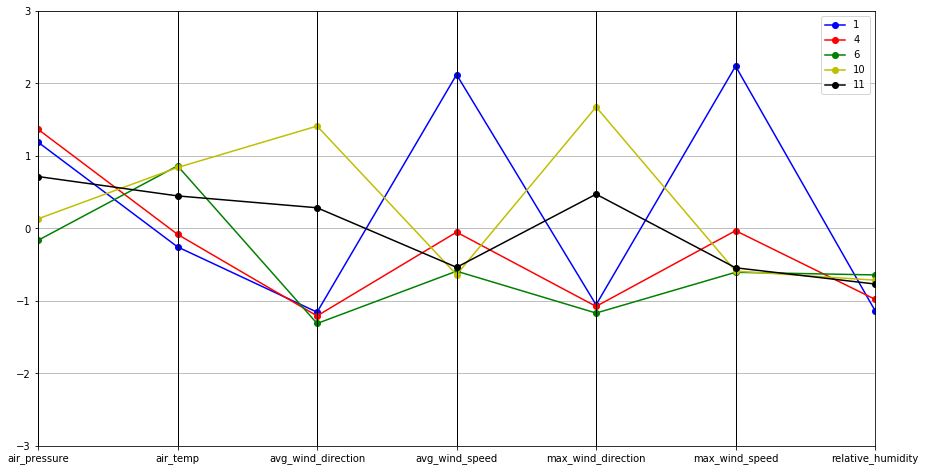

In [24]:
parallel_plot(P[P['relative_humidity'] < -0.5])

### Warm Days:
A warm day will have air temperature greater than 0.5

C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 'pandas.tools.plotting.parallel_coordinates' is deprecated, import 'pandas.plotting.parallel_coordinates' instead.
  


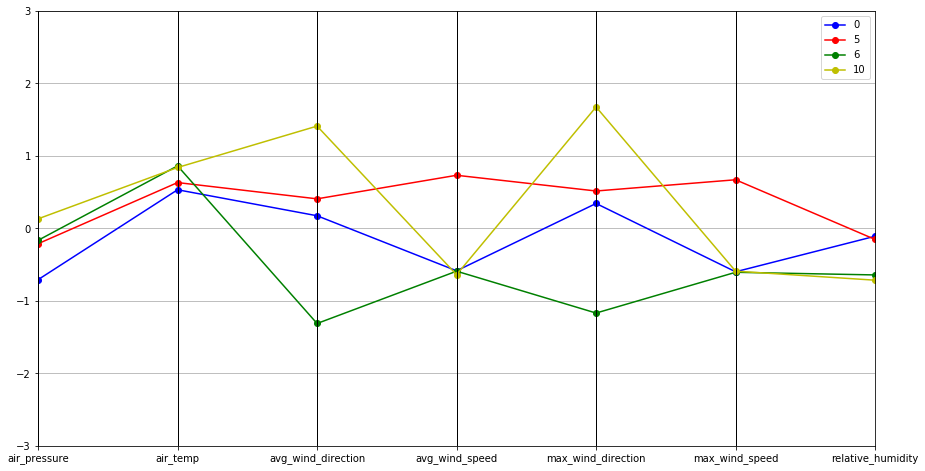

In [25]:
parallel_plot(P[P['air_temp'] > 0.5])

### Cool Days:
A cool day will have relative humidity greater than 0.5 and air temperature less than 0.5

C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 'pandas.tools.plotting.parallel_coordinates' is deprecated, import 'pandas.plotting.parallel_coordinates' instead.
  


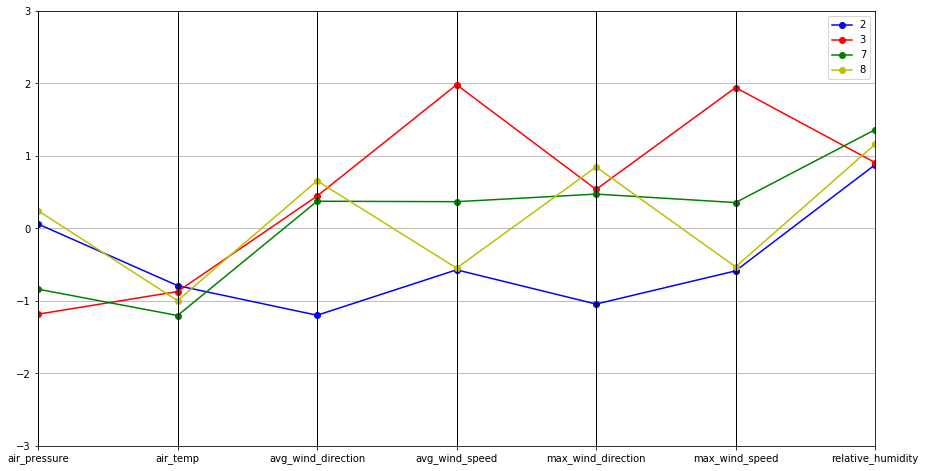

In [26]:
parallel_plot(P[(P['relative_humidity'] > 0.5) & (P['air_temp'] < 0.5)])